#  **Text Summarisation and Sentiment Analysis**

# Setting Up:
This step involves installing the packages and importing them proactively

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [ ]:
!pip3 install datasets contractions rouge tensorflow transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# for data
import datasets  #(1.13.3)
import pandas as pd  #(0.25.1)
import numpy as np #(1.16.4)

# for plotting
import matplotlib.pyplot as plt  #(3.1.2)
import seaborn as sns  #(0.9.0)

# for preprocessing
import re
import nltk  #(3.4.5)
import contractions  #(0.0.18)
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

# for evaluation
import rouge  #(1.0.0)
import difflib

# for extracted frequency based approach
from heapq import nlargest

# for textrank
import gensim  

# for seq2seq
from tensorflow.keras import callbacks, models, layers, preprocessing as kprocessing #(2.6.0)

# for bart
import transformers  #(3.0.1)

# for code cleanliness
from IPython.core.display import display, HTML


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Loading Data

Here we are loading a sample dataset of news articles and their highlights which will be considered the aim of our text summarisation alogrithms.

This Dataset is availabe in the datasets package imported above.

In [ ]:
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(list(dataset['train'])).rename(columns={"article":"text", 
      "highlights":"y"})[["text","y"]].head(10000)

SAMPLES = 20
df_train = df.iloc[SAMPLES + 1: 4 * SAMPLES]
df_test = df.iloc[:SAMPLES + 1]

## Setting Evaluation Functions

To compare the models that we will be using in this proeject, it is important to define parameters of comparison. Here we are going to use the 'rougue' library to evaluate our summaries


In [ ]:
def evaluate_summary(expected: list, predicted: list):    
  rouge_score = rouge.Rouge()    
  scores = rouge_score.get_scores(expected, predicted, avg=True)       
  score_1 = round(scores['rouge-1']['f'], 2)    
  score_2 = round(scores['rouge-2']['f'], 2)    
  score_L = round(scores['rouge-l']['f'], 2)    
  print("rouge1:", score_1, "| rouge2:", score_2, "| rougeL:",
        score_2, "--> avg rouge:", round(np.mean(
        [score_1,score_2,score_L]), 2))

# Setting Visualisation Functions

It is useful for our purposes to be able to see what parts of the full text and the summary match one another. This will allow us to see what parts were extracted and considered important

This part of the code has been adapted from:
https://gist.github.com/mdipietro09/8c9d50476488b12b34694e1292a67f80#file-display_string_matching-py

In [ ]:
def split_sentences(a: str, b: str):
  match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
  lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
  if len(lst_match) == 0:
      lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
  else:
      first_m, last_m = lst_match[0], lst_match[-1]
      string = a[0 : first_m.a]
      lst_a = [t for t in nltk.sent_tokenize(string)]
      for n in range(len(lst_match)):
          m = lst_match[n]
          string = a[m.a : m.a+m.size]
          lst_a.append(string)
          if n+1 < len(lst_match):
              next_m = lst_match[n + 1]
              string = a[m.a+m.size : next_m.a]
              lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
          else: break
      string = a[last_m.a+last_m.size :]
      lst_a += [t for t in nltk.sent_tokenize(string)]
      string = b[0 : first_m.b]
      lst_b = [t for t in nltk.sent_tokenize(string)]
      for n in range(len(lst_match)):
          m = lst_match[n]
          string = b[m.b : m.b+m.size]
          lst_b.append(string)
          if n+1 < len(lst_match):
              next_m = lst_match[n+1]
              string = b[m.b+m.size : next_m.b]
              lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
          else:
              break
      string = b[last_m.b+last_m.size :]
      lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
  return lst_a, lst_b

def display_string_matching(a: str, b: str, both=True, sentences=True, titles=[]) -> str:
  if sentences:
      lst_a, lst_b = split_sentences(a, b)
  else:
      lst_a, lst_b = a.split(), b.split()       
  first_text = []
  for i in lst_a:
      if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
          first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
      else:
          first_text.append(i)
  first_text = ' '.join(first_text)
  second_text = []
  if both is True:
      for i in lst_b:
          if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
              second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
          else:
              second_text.append(i)
  else:
      second_text.append(b) 
  second_text = ' '.join(second_text)

  if len(titles) > 0:
      first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
  if len(titles) > 1:
      second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
  else:
      second_text = "---"*65+"<br><br>"+second_text
  final_text = first_text +'<br><br>'+ second_text
  return final_text

In [ ]:
def visualise_differance(full_text: str, summary: str):
  html = display_string_matching(full_text, summary)
  display(HTML(html))


# Constructing an Extractive Appoach based on Frequency Method

This is the first straightforward approach where we measure the frequency of sentences and then score sentences and pick the n largest ones to construct the summary

This approach is created manually using no external packages.

In [ ]:
def preprocessed(document):
  from string import punctuation
  punctuation = punctuation + '\n'
  stopwords = list(STOP_WORDS)
  return [word for word in document if word.text.lower() not in stopwords and word.text.lower() not in punctuation]

def get_normalised_word_frequencies(document):
  word_frequencies = {}
  for word in preprocessed(document):
      word_frequencies[word.text] = 1 if word.text not in word_frequencies else word_frequencies[word.text] + 1
  max_frequency = max(word_frequencies.values())
  for word in word_frequencies:
    word_frequencies[word] /= max_frequency
  return word_frequencies

def extracted_summary(text: str, percentage_reduced = 0.1) -> str:
  nlp = spacy.load('en_core_web_sm')
  doc = nlp(text)
  tokens = [token.text for token in doc]
  word_frequencies = get_normalised_word_frequencies(doc)
  sentence_scores = {sent: sum([word_frequencies[word.text.lower()] 
                                for word in sent if word.text.lower() in word_frequencies]) 
                                for sent in list(doc.sents)}
  select_length = int(len(list(doc.sents)) * percentage_reduced)
  summary = nlargest(select_length, sentence_scores, key = sentence_scores.get) 
  return ' '.join([word.text for word in summary])


In [ ]:
def extracted_approach(corpus, percentage_reduced=0.2):    
    if type(corpus) is str:        
       corpus = [corpus]    
    return [extracted_summary(txt, percentage_reduced=percentage_reduced) for txt in corpus]    

In [ ]:
predicted_summaries = extracted_approach(df_test["text"], percentage_reduced=0.2)

In [ ]:
sample_predicted_summary, sample_expected_summary = predicted_summaries[0], df_test["y"][0]
evaluate_summary(sample_predicted_summary, sample_expected_summary)
print(f"For {SAMPLES} summaaries:")
evaluate_summary(predicted_summaries, list(df_test["y"]))

rouge1: 0.25 | rouge2: 0.17 | rougeL: 0.17 --> avg rouge: 0.22
For 20 summaaries:
rouge1: 0.22 | rouge2: 0.07 | rougeL: 0.07 --> avg rouge: 0.16


In [ ]:
visualise_differance(sample_predicted_summary, df_test["text"][0])

# Another Extractive Approach:  The TextRank Algorithm 

Based on the the page rank algorithm (by google) from the original internet days, this approach is also extractive and similar to the frequency mehtod. For this we are using a pretrained model form genism

In [ ]:
def textrank(corpus, ratio=0.2):    
    if type(corpus) is str:        
       corpus = [corpus]    
    return [gensim.summarization.summarize(txt, ratio=ratio) for txt in corpus]    

In [ ]:
predicted_summaries = textrank(corpus=df_test["text"], ratio=0.2)

In [ ]:
sample_predicted_summary, sample_expected_summary = predicted_summaries[0], df_test["y"][0]
evaluate_summary(sample_predicted_summary, sample_expected_summary)
print(f"For {SAMPLES} summaaries:")
# len(predicted_summaries), len(list(df_test["y"]))
evaluate_summary(predicted_summaries, list(df_test["y"]))

rouge1: 0.27 | rouge2: 0.18 | rougeL: 0.18 --> avg rouge: 0.24
For 20 summaaries:
rouge1: 0.25 | rouge2: 0.09 | rougeL: 0.09 --> avg rouge: 0.19


In [ ]:
visualise_differance(sample_predicted_summary, df_test["text"][0])

# An Abstractive Approach:  Seq2Seq

This approach uses the famous sequence to sequence nueral network.

In [ ]:
def preprocessed(text: str) -> str:
    text = re.sub(r'\.(?=[^ \W\d])', '. ', str(text))
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word.strip() for word in text.split()])
    text = contractions.fix(text.lower())   
    tokens = text.split()
    stemmer = nltk.stem.porter.PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    tokens = [lem.lemmatize(word) for word in tokens]
    stopwords = ["cnn","say","said","new"] + list(STOP_WORDS)
    tokens = [word for word in tokens if word not in stopwords]
    return " ".join(tokens)

In [ ]:
df_train["text_clean"] = df_train["text"].apply(preprocessed)
df_train["y_clean"] = df_train["y"].apply(preprocessed)
df_test["text_clean"] = df_test["text"].apply(preprocessed)
df_test["y_clean"] = df_test["y"].apply(preprocessed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
def frequency(column):
  tokens = nltk.tokenize.word_tokenize(column.str.cat(sep=" "))
  ngrams = [1]
  df_freq = pd.DataFrame()
  for n in ngrams:
    dic_words_freq = nltk.FreqDist(nltk.ngrams(tokens, n))
    df_n = pd.DataFrame(dic_words_freq.most_common(), columns=
                          ["word","freq"])
    df_n["ngrams"] = n
    df_freq = df_freq.append(df_n)
    df_freq["word"] = df_freq["word"].apply(lambda x: " ".join(string for string in x))
    df_freq_X = df_freq.sort_values(["ngrams","freq"], ascending=
                          [True,False])
  return df_freq, df_freq_X

In [ ]:
df_freq_x = frequency(df_train["text_clean"])[1]
df_freq_y = frequency(df_train["y_clean"])[1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


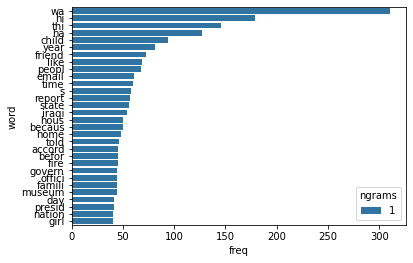

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


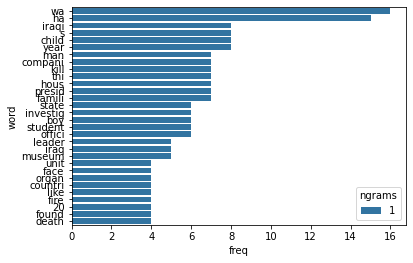

In [ ]:
sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
 data=frequency(df_train["text_clean"])[0].groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

sns.barplot(x="freq", y="word", hue="ngrams", dodge=False,
 data=frequency(df_train["y_clean"])[0].groupby('ngrams')["ngrams","freq","word"].head(30))
plt.show()

In [ ]:
thres = 5 #<-- min frequency
X_top_words = len(df_freq_x[df_freq_x["freq"] > thres])
y_top_words = len(df_freq_y[df_freq_y["freq"] > thres])

X_top_words, y_top_words

(878, 18)

In [ ]:
lst_corpus = df_train["text_clean"]
tokenizer = kprocessing.text.Tokenizer(num_words=X_top_words, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
X_dic_vocabulary = {"<PAD>":0}
X_dic_vocabulary.update(tokenizer.word_index)
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")
fitted_tokenizer = tokenizer

In [ ]:
lst_corpus = df_train["y_clean"]
tokenizer = kprocessing.text.Tokenizer(num_words=y_top_words, lower=False, split=' ', oov_token=None, 
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
y_dic_vocabulary = {"<PAD>":0}
y_dic_vocabulary.update(tokenizer.word_index)
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
y_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [ ]:
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(df_test["text_clean"])
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [ ]:
special_tokens = ("<START>", "<END>")
df_train["y_clean"] = df_train['y_clean'].apply(lambda x: 
                     special_tokens[0]+' '+x+' '+special_tokens[1])
df_test["y_clean"] = df_test['y_clean'].apply(lambda x: 
                     special_tokens[0]+' '+x+' '+special_tokens[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
tokenizer.fit_on_texts(df_train["y_clean"])
fitted_tokenizer = tokenizer

In [ ]:
import gensim.downloader as api
nlp = api.load("glove-wiki-gigaword-300")

In [ ]:
lstm_units = 250
embeddings_size = 300
##------------ ENCODER (embedding + lstm) ------------------------##
x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = layers.Embedding(name="x_emb", 
                               input_dim=len(X_dic_vocabulary),
                               output_dim=embeddings_size, 
                               trainable=True)
x_emb = layer_x_emb(x_in)
### lstm 
layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
x_out, state_h, state_c = layer_x_lstm(x_emb)
##------------ DECODER (embedding + lstm + dense) ----------------##
y_in = layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = layers.Embedding(name="y_emb", 
                               input_dim=len(y_dic_vocabulary), 
                               output_dim=embeddings_size, 
                               trainable=True)
y_emb = layer_y_emb(y_in)
### lstm 
layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, 
                           dropout=0.4, return_sequences=True, 
                           return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = layers.TimeDistributed(name="dense",          layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)
##---------------------------- COMPILE ---------------------------##
model = models.Model(inputs=[x_in, y_in], outputs=y_out, 
                     name="Seq2Seq")
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "Seq2Seq"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_in (InputLayer)              [(None, 15)]         0           []                               
                                                                                                  
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 x_emb (Embedding)              (None, 15, 300)      1561200     ['x_in[0][0]']                   
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    288900      ['y_in[0][0]']                   
                                                                                            

In [ ]:
# Prediction Encoder
encoder_model = models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
encoder_model.summary()

Model: "Prediction_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x_in (InputLayer)           [(None, 15)]              0         
                                                                 
 x_emb (Embedding)           (None, 15, 300)           1561200   
                                                                 
 x_lstm (LSTM)               [(None, 15, 250),         551000    
                              (None, 250),                       
                              (None, 250)]                       
                                                                 
Total params: 2,112,200
Trainable params: 2,112,200
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Prediction Decoder
## double the lstm units if you used bidirectional lstm
lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
## states of the previous time step
encoder_out = layers.Input(shape=(X_train.shape[1], lstm_units))
state_h, state_c = layers.Input(shape=(lstm_units,)), layers.Input(shape=(lstm_units,))
## decoder embeddings
y_emb2 = layer_y_emb(y_in)
## lstm to predict the next word
y_out2, state_h2, state_c2 = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])
## softmax to generate probability distribution over the vocabulary
probs = layer_dense(y_out2)
## compile
decoder_model = models.Model(inputs=[y_in, encoder_out, state_h, state_c], outputs=[probs, state_h2, state_c2], name="Prediction_Decoder")
decoder_model.summary()

Model: "Prediction_Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    288900      ['y_in[0][0]']                   
                                                                                                  
 input_2 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 250)]        0           []                               
                                                                                 

In [ ]:
# Predict
max_seq_lenght = X_test.shape[1]
predicted = []
for x in X_test:
   x = x.reshape(1,-1)
   ## encode X
   encoder_out, state_h, state_c = encoder_model.predict(x)
   ## prepare loop
   y_in = np.array([fitted_tokenizer.word_index[special_tokens[0]]])
   predicted_text = ""
   stop = False
   while not stop:
        ## predict dictionary probability distribution
        probs, new_state_h, new_state_c = decoder_model.predict(
                          [y_in, encoder_out, state_h, state_c])
        
        ## get predicted word
        voc_idx = np.argmax(probs[0,-1,:])
        pred_word = fitted_tokenizer.index_word[voc_idx]
        
        ## check stop
        if (pred_word != special_tokens[1]) and (len(predicted_text.split()) < max_seq_lenght):
            predicted_text = predicted_text +" "+ pred_word
        else:
            stop = True
        
        ## next
        y_in = np.array([voc_idx])
        state_h, state_c = new_state_h, new_state_c
   predicted_text = predicted_text.replace(
                    special_tokens[0],"").strip()
   predicted.append(predicted_text)


# The Best Known Abstractive Approach: Using BART 

BART is an algot

In [ ]:
def bart(corpus):    
    summarizer = transformers.pipeline("summarization", model="facebook/bart-large-cnn") 
    summaries = []
    for text in corpus:
      try:
        summaries.append(summarizer(text, max_length=500, min_length=30, do_sample=False))
      except:
        summaries.append(" ")
    return [s[0]["summary_text"].replace(" .", ".") for s in summaries]    

In [ ]:
predicted_summaries = bart(df_test["text"])

Token indices sequence length is longer than the specified maximum sequence length for this model (1196 > 1024). Running this sequence through the model will result in indexing errors
Your max_length is set to 500, but you input_length is only 454. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=227)
Your max_length is set to 500, but you input_length is only 466. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=233)
Your max_length is set to 500, but you input_length is only 402. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=201)
Your max_length is set to 500, but you input_length is only 301. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=150)
Your max_length is set to 500, but you input_length is only 271. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=135)
Your max_length is set to 500, but you in

TypeError: ignored

In [ ]:
sample_predicted_summary, sample_expected_summary = predicted_summaries[0], df_test["y"][0]
evaluate_summary(sample_predicted_summary, sample_expected_summary)
print(f"For {SAMPLES} summaaries:")
evaluate_summary(predicted_summaries, list(df_test["y"]))

In [ ]:
visualise_differance(sample_predicted_summary, df_test["text"][0])

# Sentiment Analysis of Text

Similar to the construction of any NLP model, this process would involve processing the data, tokenizing it and using the fitted tokenizer to transform it. 

For this part of the project we will heavily utilise the tensorflow library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [ ]:
sentiments = ["positive", "negative", "nuetral"]

In [ ]:
texts = df_train["y"]
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(texts)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           38848     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 55,499
Trainable params: 55,499
Non-trainable params: 0
__________________________________________________

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    return sentiments[prediction]

In [ ]:
df_test["sentiment"] = [predict_sentiment(s) for s in df_test["y"]]

In [ ]:
df_test

In [ ]:
predict_sentiment("Kalawati, the widow of a farmer who had committed suicide in Yavatmal managed to meet Rahul Gandhi, who had spoken of her in parliament in 2008, to thank him.")

1/1 [==============================] - 2s 2s/step


'positive'